In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import pandas_ta as ta

In [2]:
# Define the stock ticker and date range
ticker = 'AAPL'
start_date = '2018-01-01'
end_date = '2023-01-01'

# Download the data
df = yf.download(ticker, start=start_date, end=end_date)

C:\Users\Hp\AppData\Local\Temp\ipykernel_20192\1814452998.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [3]:

df = pd.read_csv("data.csv")

In [4]:
df.head()

,Price,Close,High,Low,Open,Volume
0,Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
1,Date,NaN,NaN,NaN,NaN,NaN
2,2024-06-03,193.1267852783203,194.08232314185275,191.62381982592728,192.002040590698,50080500
3,2024-06-04,193.4453125,194.41079839334418,192.13144977133211,193.7339558758535,47471400
4,2024-06-05,194.95823669433594,195.9834409155792,193.96289161058436,194.49042328995185,54156800


In [5]:
df.columns

Index(['Price', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Price   251 non-null    object
 1   Close   250 non-null    object
 2   High    250 non-null    object
 3   Low     250 non-null    object
 4   Open    250 non-null    object
 5   Volume  250 non-null    object
dtypes: object(6)
memory usage: 11.9+ KB


In [7]:
df.describe()

,Price,Close,High,Low,Open,Volume
count,251,250,250,250,250,250
unique,251,248,250,250,250,250
top,Ticker,221.9896697998047,AAPL,AAPL,AAPL,AAPL
freq,1,2,1,1,1,1


In [8]:
# Preprocessing of data

df.isnull().sum()


Price     0
Close     1
High      1
Low       1
Open      1
Volume    1
dtype: int64

In [9]:
df.rename(columns={"Price" : "Date"}, inplace=True)

In [10]:
# encoding convert object columns to numeric
df[[ "Close" , "Low" ,"High" , "Open" , "Volume"]] = df[["Close" , "Low" ,"High" ,  "Open" , "Volume"]].apply(pd.to_numeric, errors = "coerce")

In [11]:
# Dealing with missing values
df.dropna(inplace = True)

In [12]:
df.isnull().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [13]:
df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
df.set_index("Date", inplace=True)


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249 entries, 2024-06-03 to 2025-05-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   249 non-null    float64
 1   High    249 non-null    float64
 2   Low     249 non-null    float64
 3   Open    249 non-null    float64
 4   Volume  249 non-null    float64
dtypes: float64(5)
memory usage: 11.7 KB


In [15]:
df.reset_index(inplace=True)

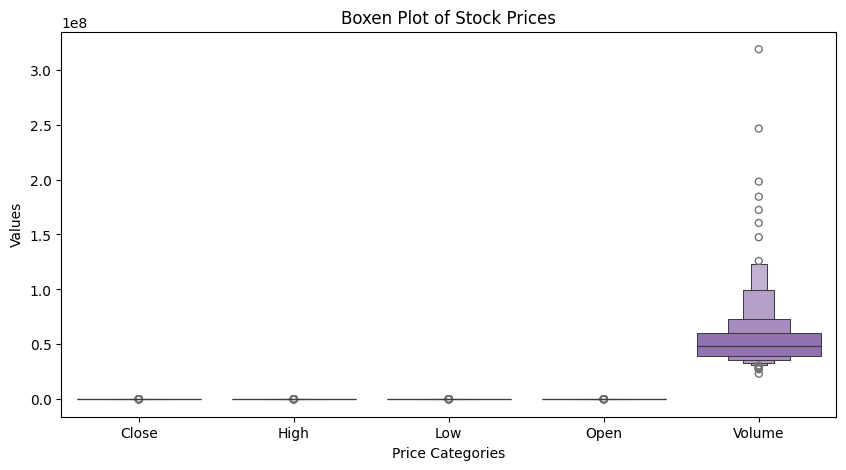

In [16]:

# identifying outliers using Plotting
# Create a boxen plot for stock prices
plt.figure(figsize=(10, 5))
sns.boxenplot(data = df[["Close", "High", "Low", "Open" , "Volume"]])
plt.title("Boxen Plot of Stock Prices")
plt.xlabel("Price Categories")
plt.ylabel("Values")
plt.show()

In [17]:
# Removing outliers using IQR method
# Compute IQR bounds
q1 = df[["Close", "High", "Low", "Open", "Volume"]].quantile(0.25)
q3 = df[["Close", "High", "Low", "Open", "Volume"]].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 3.0 * iqr
upper_bound = q3 + 3.0 * iqr

outlier_rows = df[((df[["Close", "High", "Low", "Open", "Volume"]] < lower_bound) | (df[["Close", "High", "Low", "Open", "Volume"]] > upper_bound)).any(axis=1)]


In [18]:
# Print number of rows with outliers
print("Number of rows with outliers:" ,outlier_rows.shape[0])

# Print index numbers of outlier rows
print("Indexes of outlier rows:", outlier_rows.index.tolist())


Number of rows with outliers: 8
Indexes of outlier rows: [6, 7, 13, 76, 140, 210, 211, 213]


In [19]:
 # Identify and remove outlier rows
df_cleaned = df[~((df[["Close", "High", "Low", "Open", "Volume"]] < lower_bound) |
                     (df[["Close", "High", "Low", "Open", "Volume"]] > upper_bound)).any(axis=1)]

In [20]:
outlier_rows = df_cleaned[((df_cleaned[["Close", "High", "Low", "Open", "Volume"]] < lower_bound) | 
                            (df_cleaned[["Close", "High", "Low", "Open", "Volume"]] > upper_bound)).any(axis=1)]

# Print number of rows with outliers
print("Number of rows with outliers:" ,outlier_rows.shape[0])

# Print index numbers of outlier rows
print("Indexes of outlier rows:", outlier_rows.index.tolist())


Number of rows with outliers: 0
Indexes of outlier rows: []


In [21]:
df_cleaned.dtypes

Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume           float64
dtype: object

In [22]:
df_cleaned = df_cleaned[df_cleaned["Volume"] > 1000].copy()


In [23]:
# Normalization of data or Standardization
scaler = StandardScaler()
df_cleaned.loc[:, ["High", "Open", "Low", "Close", "Volume"]] = scaler.fit_transform(
    df_cleaned[["High", "Open", "Low", "Close", "Volume"]]
)

In [24]:
# Calculate financial indicators 

# 1. Simple Moving Average (SMA)
df_cleaned.loc[:, "SMA_20"] = df_cleaned.ta.sma(length=20, close="Close")

In [25]:
# 2. Exponential Moving Average (EMA)
df_cleaned.loc[:, "EMA_20"] = df_cleaned.ta.ema(length=20, close="Close")

In [26]:
# 3. Relative Strength Index (RSI)
df_cleaned.loc[:, "RSI_14"] = df_cleaned.ta.rsi(length=14, close="Close")

In [27]:
# 4. Bollinger Bands

# Compute Bollinger Bands from the entire DataFrame
bb = df_cleaned.ta.bbands(length=20, std=2, close="Close")
# Concatenate the bands to your original DataFrame
df_cleaned = pd.concat([df_cleaned, bb], axis=1)

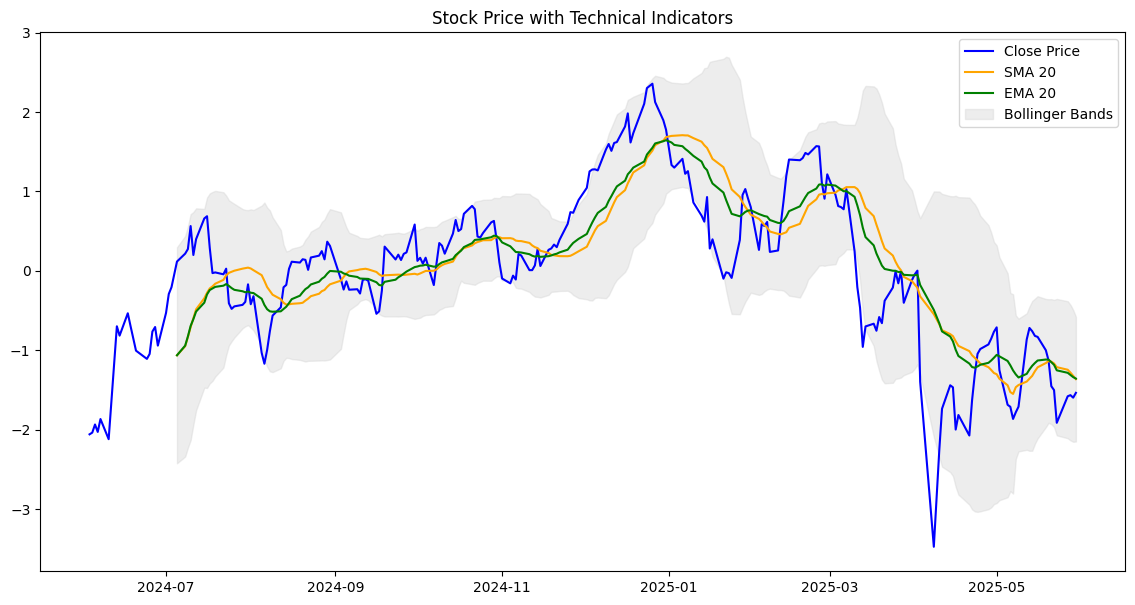

In [28]:
plt.figure(figsize=(14,7))
plt.plot(df_cleaned["Date"], df_cleaned["Close"], label="Close Price", color='blue')
plt.plot(df_cleaned["Date"], df_cleaned["SMA_20"], label="SMA 20", color='orange')
plt.plot(df_cleaned["Date"], df_cleaned["EMA_20"], label="EMA 20", color='green')
plt.fill_between(df_cleaned["Date"], df_cleaned["BBL_20_2.0"], df_cleaned["BBU_20_2.0"], color='lightgray', alpha=0.4, label='Bollinger Bands')
plt.title("Stock Price with Technical Indicators")
plt.legend()
plt.show()

In [29]:
df_cleaned.isnull().sum()

Date           0
Close          0
High           0
Low            0
Open           0
Volume         0
SMA_20        19
EMA_20        19
RSI_14        14
BBL_20_2.0    19
BBM_20_2.0    19
BBU_20_2.0    19
BBB_20_2.0    19
BBP_20_2.0    19
dtype: int64

In [30]:
df_cleaned.dropna(inplace=True)

In [31]:
# 3. Use Isolation Forest or DBSCAN for unsupervised anomaly detection.

# select features for anomaly dedection 
features = ["Close" , "Volume" , "RSI_14", "SMA_20", "EMA_20", "BBL_20_2.0", "BBM_20_2.0", "BBU_20_2.0"]
x = df_cleaned[features].copy()

# Initialize and fit the Isolation Forest model
isf = IsolationForest(n_estimators=100 , contamination=0.02,random_state=42)
df_cleaned['anomaly'] = isf.fit_predict(x)

# convert predictions: -1 = anomaly, 1 = normal
df_cleaned["anomaly_flag"] = df_cleaned["anomaly"].map({1: 0, -1: 1})



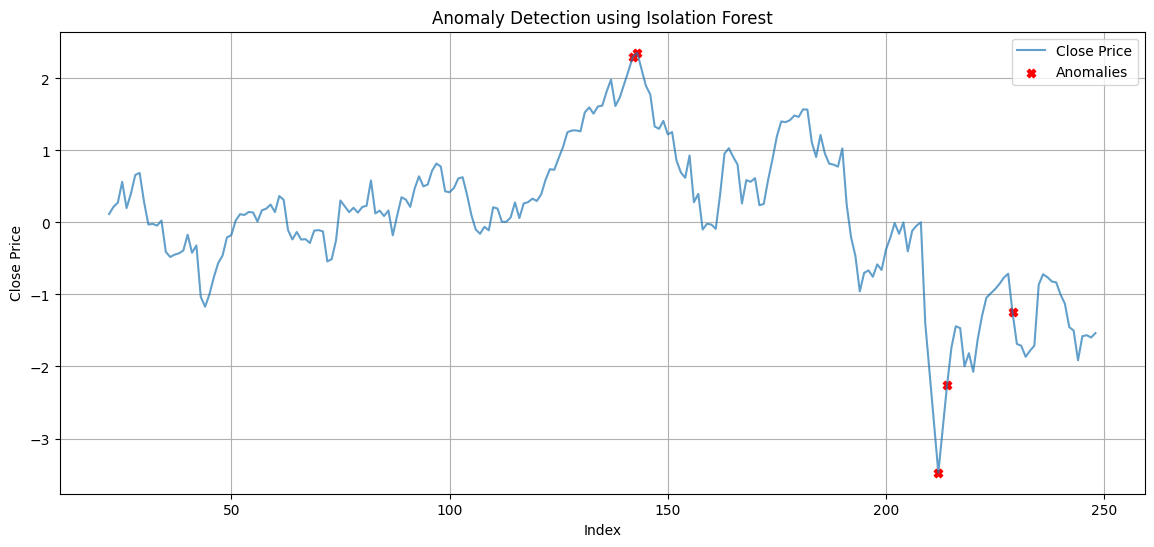

In [32]:
# Visualize Anomalies on Close Pric
plt.figure(figsize=(14, 6))
plt.plot(df_cleaned["Close"], label="Close Price", alpha=0.7)
plt.scatter(df_cleaned[df_cleaned["anomaly_flag"] == 1].index,
            df_cleaned[df_cleaned["anomaly_flag"] == 1]["Close"],
            color='red', label="Anomalies", marker='X')
plt.title("Anomaly Detection using Isolation Forest")
plt.xlabel("Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Step 4: Time-Series Forecasting with LSTM (Long-short-time-memory)
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [34]:
# Use Close price only
close_scaled = df_cleaned["Close"].values.reshape(-1, 1)

# Create sliding windows
window_size = 60  # 60-day sequence
X, y = create_sequences(close_scaled, window_size)

# Reshape for LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [35]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
4/4 [==============================] - 3s 207ms/step - loss: 1.2075 - val_loss: 1.7099
Epoch 2/20
4/4 [==============================] - 0s 57ms/step - loss: 1.0377 - val_loss: 1.6894
Epoch 3/20
4/4 [==============================] - 0s 44ms/step - loss: 0.9055 - val_loss: 1.6636
Epoch 4/20
4/4 [==============================] - 0s 53ms/step - loss: 0.7732 - val_loss: 1.6390
Epoch 5/20
4/4 [==============================] - 0s 63ms/step - loss: 0.6456 - val_loss: 1.6157
Epoch 6/20
4/4 [==============================] - 0s 61ms/step - loss: 0.5202 - val_loss: 1.5991
Epoch 7/20
4/4 [==============================] - 0s 53ms/step - loss: 0.3903 - val_loss: 1.6146
Epoch 8/20
4/4 [==============================] - 0s 72ms/step - loss: 0.3645 - val_loss: 1.5071
Epoch 9/20
4/4 [==============================] - 0s 69ms/step - loss: 0.3350 - val_loss: 1.4490
Epoch 10/20
4/4 [==============================] - 0s 61ms/step - loss: 0.3425 - val_loss: 1.3923
Epoch 11/20
4/4 [===========

In [36]:
predictions = model.predict(X_test)

# Inverse scale if needed (only if you saved the scaler)
# predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 0s 11ms/step


In [37]:
residuals = abs(predictions.flatten() - y_test.flatten())
threshold = np.percentile(residuals, 98)  # Top 2% deviations
anomaly_indices = residuals > threshold

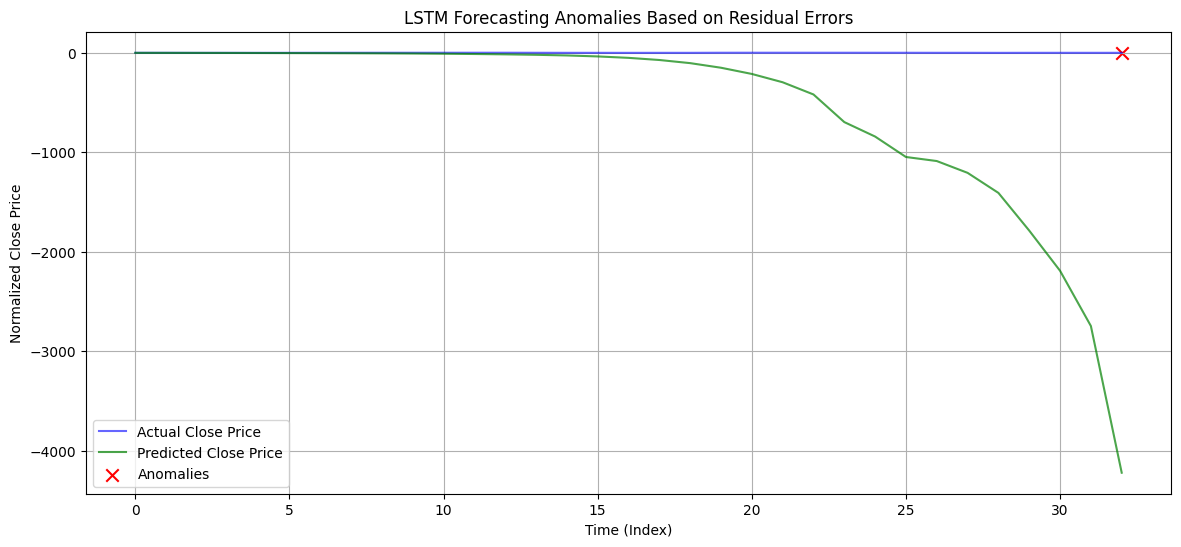

In [38]:
# Plot predictions and anomalies on top of the actual prices
plt.figure(figsize=(14,6))
plt.plot(range(len(y_test)), y_test, label='Actual Close Price', color='blue', alpha=0.6)
plt.plot(range(len(predictions)), predictions, label='Predicted Close Price', color='green', alpha=0.7)

# Highlight anomaly points
plt.scatter(np.where(anomaly_indices), y_test[anomaly_indices], color='red', marker='x', s=80, label='Anomalies')

plt.title("LSTM Forecasting Anomalies Based on Residual Errors")
plt.xlabel("Time (Index)")
plt.ylabel("Normalized Close Price")
plt.legend()
plt.grid(True)
plt.show()